In [3]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pydub
import sounddevice as sd
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write

In [4]:
img = cv.imread("AveMaria.png", cv.IMREAD_GRAYSCALE)

In [5]:
def detectLines(img):
    dst = cv.Canny(img, 50, 200, None, 3)

    cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)

    linesP = cv.HoughLinesP(dst, 1, np.pi / 180, 50, None, 50, 10)

    lines_x = []
    lines_y = []

    for i in range(0, len(linesP)):
        l = linesP[i][0]

        if (abs(l[0] - l[2]) <= 1):
            continue

        if (lines_x == [] or lines_y == []):
            lines_x.append(l[0])
            lines_y.append(l[1])

        if (abs(lines_y[-1] - l[1]) < 1):
            continue
        else:
            lines_x.append(l[0])
            lines_y.append(l[1])

    lines_x = np.asarray(lines_x)
    lines_y = np.asarray(lines_y)

    index = np.argsort(lines_y)
    lines_x = lines_x[index]
    lines_y = lines_y[index]

    diff = np.diff(lines_y)
    indices_toKeep = [0]
    for i in range(diff.shape[-1]):
        if (diff[i] > 5):
            indices_toKeep.append(i+1)

    lines_x = lines_x[indices_toKeep]
    lines_y = lines_y[indices_toKeep]

    for i in range(lines_y.shape[-1]):
        cv.line(cdst, (0, lines_y[i]), (1740, lines_y[i]), (0,0,255), 3, cv.LINE_AA)
    
    return lines_x, lines_y, cdst

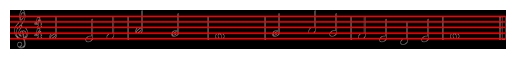

In [6]:
lines_x, lines_y, cdst = detectLines(img)

_ = plt.imshow(cdst[:,:,(2,1,0)])
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.box(0)

In [7]:
def detectNotes(img, template, threshold, dur):
    img2 = img.copy()
    
    w, h = template.shape[::-1]

    res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    rects = list(zip(*loc[::-1], loc[0].shape[0]*[dur]))
    rects = sorted(rects, key = lambda x: (x[0], x[1]))
    rects = np.asarray(rects)
    
    keep = [0]
    x_margin = 20
    y_margin = 20
    prev_x = rects[0][0]
    prev_y = rects[0][1]

    for i in range(1, rects.shape[0]):
        if (abs(rects[i][0] - prev_x) > x_margin or abs(rects[i][1] - prev_y) > y_margin):
            keep.append(i)
            prev_x = rects[i][0]
            prev_y = rects[i][1]

    rects = rects[keep]

    for pt in rects:
        cv.rectangle(img2, pt[0:2], (pt[0] + w, pt[1] + h), (0,0,255), 2)
    
    rects = rects + [0, h - 7 if dur == 4 else h - 11, 0]
    
    return rects, img2

def attachNotes(rectsQ, rectsH, rectsW):
    rects = np.ndarray.tolist(rectsQ)
    rects.extend(np.ndarray.tolist(rectsH))
    rects.extend(np.ndarray.tolist(rectsW))

    rects = sorted(rects, key = lambda x: (x[0], x[1]))
    
    rects = np.asarray(rects)
    
    return rects

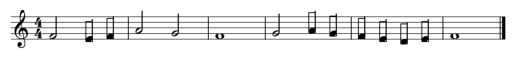

In [11]:
template1 = cv.imread("quarter.PNG", cv.IMREAD_GRAYSCALE)
template2 = cv.imread("half.PNG", cv.IMREAD_GRAYSCALE)
template3 = cv.imread("whole.PNG", cv.IMREAD_GRAYSCALE)

thresholdQ = 0.7
thresholdH = 0.75
thresholdW = 0.5

rectsQ, imgQ = detectNotes(img, template1, thresholdQ, 4)
rectsH, imgH = detectNotes(img, template2, thresholdH, 2)
rectsW, imgW = detectNotes(img, template3, thresholdW, 0)

rects = attachNotes(rectsQ, rectsH, rectsW)

_ = plt.imshow(imgQ, cmap = plt.cm.gray)
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.box(0)

In [137]:
def compile_Music(rects):
    onLine_margin = 4
    betweenLine_margin = 10

    music_lines = []

    for note in rects:
        diffs = abs(lines_y - note[1])
        potentials = np.argsort(diffs)

        if (diffs[potentials[0]] <= onLine_margin):
            music_lines.append(potentials[0] + 1)
        elif (diffs[potentials[0]] <= betweenLine_margin):
            music_lines.append((potentials[0] + potentials[1])/2 + 1)
        else:
            music_lines.append(5.5)
            
    compiled_music = []

    for i, note in enumerate(music_lines):
        if (note == 6):
            compiled_music.append([3,4,rects[i][2]])
        elif (note == 5.5):
            compiled_music.append([5,4,rects[i][2]])
        elif (note == 5):
            compiled_music.append([7,4,rects[i][2]])
        elif (note == 4.5):
            compiled_music.append([8,4,rects[i][2]])
        elif (note == 4):
            compiled_music.append([10,4,rects[i][2]])
        elif (note == 3.5):
            compiled_music.append([0,4,rects[i][2]])
            
    return compiled_music

In [138]:
compiled_music = compile_Music(rects)

In [140]:
def getDurations(tempo, fs):
    whole_note = 4*60*fs/tempo
    durs = np.array([[whole_note/(2**i),dotted(whole_note/(2**i))] for i in range(6)])
    
    return durs.flatten()

def dotted(dur):
    return dur*1.5

def sin_wave(f, n, fs):
    x = np.linspace(0, 2*np.pi, n)
    xp = np.linspace(0, -1*(n*ring/fs), n)
    y = np.sin(x*f*(n/fs))*np.exp(xp)
    z = np.zeros([n, 2])
    z[:, 0] = y
    z[:, 1] = y
    return z

def play_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]), fs)
    sd.play(y, fs)
    sd.wait()
    return 

def put_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]), fs)
    return y

def get_music(music_notes, fs):
    m = []
    for item in music_notes:
        y = put_note(item[0], item[1], item[2], fs)
        m.append(y)
    m = np.concatenate(m, 0)
    return m

In [142]:
notes_base = 2**(np.arange(12)/12)*27.5 # A0; A4= 440 Hz
tempo = 120
ring = 3 # how long the sine wave rings. lower value = more ringing/sustain
fs = 44100
notes_duration = getDurations(tempo,fs)
"""
    Whole note = 0
    Dotted whole note = 1
    Half note = 2
    Dotted half note = 3
    Quarter note = 4
    Dotted quarter note = 5
    etc.
"""
notes_ann = ['A', 'A#', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#']

avemaria = compiled_music

y = get_music(avemaria, fs)
sd.play(y, fs)

In [143]:
write("avemaria.wav", fs, y.astype(np.float32))